# Prediction/ Interpolation  Experiments
**Tables/Figures**: Figure 3, Supp Fig 2

This notebook generates barplots for prediction and interpolation (sparsity) experiments - uses calculated error from [this script](sparsity_prediction_process.py)

In [1]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%load_ext autoreload
%autoreload 2

In [2]:
from analysis_utils import *

import joblib
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path 
from statannot import add_stat_annotation
import seaborn as sns

sns.set(font_scale=2.5, style="white", color_codes=False)

In [3]:
def process_err_df(mod_obj):
    """Convert ModelSum object to pandas dataframe summarizing info"""
    df = pd.DataFrame()
    for key in mod_obj.keys():
        curdf = pd.DataFrame(mod_obj[key].err, columns=['err']).dropna()
        curdf['task_num'] = mod_obj[key].task_num
        curdf['seed'] = mod_obj[key].seed
        curdf['type'] = mod_obj[key].mod_type
        curdf['best_ll']=mod_obj[key].best_ll
        df = df.append(curdf)
    return(df)        

def process_num_clust(mod_obj):
    """Get number of clusters in model"""
    df = pd.DataFrame(columns=['num_clust', 'best_ll', 'neg_best_ll', 'task_num', 'seed', 'type'])
    for key in mod_obj.keys():
        df.loc[key] = pd.Series({'num_clust':mod_obj[key].num_clust, 'best_ll':mod_obj[key].best_ll, 'neg_best_ll':-mod_obj[key].best_ll, 'task_num':mod_obj[key].task_num, 'seed':mod_obj[key].seed, 'type': mod_obj[key].mod_type})
    return(df)
            
def gen_err_merge(mod_obj_dict):
    """For best MAP seeds, get number of clusters and error"""
    df_cn_merge = pd.DataFrame()
    df_err_merge = pd.DataFrame()
    
    for key in mod_obj_dict.keys():
        df_cn_merge = df_cn_merge.append(process_num_clust(mod_obj_dict[key]))
        df_err_merge = df_err_merge.append(process_err_df(mod_obj_dict[key]))  
    return(df_err_merge, df_cn_merge)

In [4]:
def plot_bars_cn(ax, df_err_merge, err_col, plot_title, legend_labels, axtitle=None, ylim=None, col_palette=None):
    """Plotting function for cluster numbers"""
    df_err_merge = df_err_merge.copy()
    df_err_merge['type'] = df_err_merge['type'].map(legend_labels)
    sns.barplot(ax=ax, x='task_num', y=err_col, hue='type',data=df_err_merge, palette=col_palette, edgecolor=".2", linewidth=2.5,  saturation=1)

    sns.despine(top=True)
    ax.set(xlabel=plot_title, ylabel='Number of Clusters')
    if ylim is not None:
        ax.set_ylim(ylim)
        
    ax.set_title(axtitle, loc='left', pad=60, fontweight="bold")
    
    handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()
    return ax, handles, labels


In [5]:
def plot_bars_task(ax, df_err_merge, err_col, plot_title, legend_labels, axtitle=None, ylim=None, yticks=None, col_palette=None):
    """Plotting function for prediction/sparsity barplot"""
    df_err_merge = df_err_merge.copy()
    df_err_merge['type'] = df_err_merge['type'].map(legend_labels)
    sns.barplot(ax=ax, x='task_num', y=err_col, hue='type',data=df_err_merge, palette=col_palette, edgecolor=".2", linewidth=2.5,  saturation=1)

    sns.despine(top=True)
    ax.set(xlabel=plot_title, ylabel='ALSFRS-R Error')
    if ylim is not None:
        ax.set_ylim(ylim)
    if yticks is not None:
        ax.set_yticks(yticks)
    kernel_types = list(df_err_merge['type'].unique())
    box_pairs = [((x, kernel_types[0]), (x, kernel_types[1])) for x in df_err_merge['task_num'].unique()]
    box_pairs_2 = [((x, kernel_types[0]), (x, kernel_types[2])) for x in df_err_merge['task_num'].unique()]
    box_pairs = box_pairs + box_pairs_2
    
    pvalue_thresholds = [[1e-4, "****"], [1e-3, "***"], [1e-2, "**"], [0.1, "*"], [1, "ns"]]
    
    test_results = add_stat_annotation(ax, x='task_num', y=err_col, hue='type', data=df_err_merge,
                                       box_pairs=box_pairs, 
                                       test='Wilcoxon', stats_params={'alternative':'less'}, text_format='star', fontsize=30,
                                       loc='outside', verbose=2, comparisons_correction=None, pvalue_thresholds=pvalue_thresholds)
    
    ax.set_title(axtitle, loc='left', pad=105, fontweight="bold")
    
    handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()
    return ax, handles, labels


In [6]:
# Load all data matrices
exp_path = Path('data/model_data/2_sparsity_prediction')
base_mods = ['rbf', 'slope', 'linear']

file_ext_dict = {'prediction': 'predict', 'sparsity':'sparse'}
err_store_dict = {}

for cur_exp in ['prediction', 'sparsity']:        
    rmse_err_path = exp_path / cur_exp / 'results' / 'rmse' 
    for cur_proj in ['ceft', 'proact']:
        tmp_store_dict = {}
        for cur_mod_type in base_mods: #change to rbf, linear
            tmp_store_dict[cur_mod_type]=joblib.load(rmse_err_path / '{}_{}_{}_rmse_err.pkl'.format(file_ext_dict[cur_exp], cur_proj, cur_mod_type))
        err_store_dict['{}_{}'.format(cur_proj, file_ext_dict[cur_exp])] = tmp_store_dict

In [7]:
ceft_sparse_err_merge, ceft_sparse_cn_merge = gen_err_merge(err_store_dict['ceft_sparse'])
ceft_pred_err_merge, ceft_pred_cn_merge = gen_err_merge(err_store_dict['ceft_predict'])

proact_sparse_err_merge, proact_sparse_cn_merge = gen_err_merge(err_store_dict['proact_sparse'])
proact_pred_err_merge, proact_pred_cn_merge = gen_err_merge(err_store_dict['proact_predict'])

# Figure 3: Barplots for prediction/interpolation - PROACT & CEFTRIAXONE

In [8]:
# Formatting params
parameters = {'axes.labelsize': 35,
              'axes.titlesize':40,
              'xtick.labelsize':30,
              'ytick.labelsize':30,
             'legend.fontsize':35,
              'font.size': 10,
             'figure.subplot.hspace':0.2,
             'figure.subplot.wspace':0.2, 
            'legend.frameon':False,
            'pdf.fonttype':42}
plt.rcParams.update(parameters)


col_palette = ['#176D9C', '#DBA137','#86AF49' ,'#df473c','#ae3c60', '#82b4bb']
legend_labels={'rbf': 'Mixture of Gaussian Processes Model (MoGP)', 'linear':'Linear Kernel Model (LKM)', 'slope':'Slope Model (SM)'}
legend_labels_cn={'rbf': 'Mixture of Gaussian Processes Model (MoGP)', 'linear':'Linear Kernel Model (LKM)'}

p-value annotation legend:
ns: 1.00e-01 < p <= 1.00e+00
*: 1.00e-02 < p <= 1.00e-01
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
75_Mixture of Gaussian Processes Model (MoGP) v.s. 75_Slope Model (SM): Wilcoxon test (paired samples), P_val=2.474e-07 stat=3.704e+05
Using zero_method  wilcox
25_Mixture of Gaussian Processes Model (MoGP) v.s. 25_Slope Model (SM): Wilcoxon test (paired samples), P_val=9.996e-01 stat=4.870e+05
Using zero_method  wilcox
50_Mixture of Gaussian Processes Model (MoGP) v.s. 50_Slope Model (SM): Wilcoxon test (paired samples), P_val=9.624e-04 stat=3.973e+05
Using zero_method  wilcox
75_Mixture of Gaussian Processes Model (MoGP) v.s. 75_Linear Kernel Model (LKM): Wilcoxon test (paired samples), P_val=8.305e-38 stat=2.619e+05
Using zero_method  wilcox
50_Mixture of Gaussian Processes Model (MoGP) v.s. 50_Linear Kernel Model (LKM): Wilcoxon test (paired samples), P_val=3.183e-43 stat=2.488e+05
Using zero_me

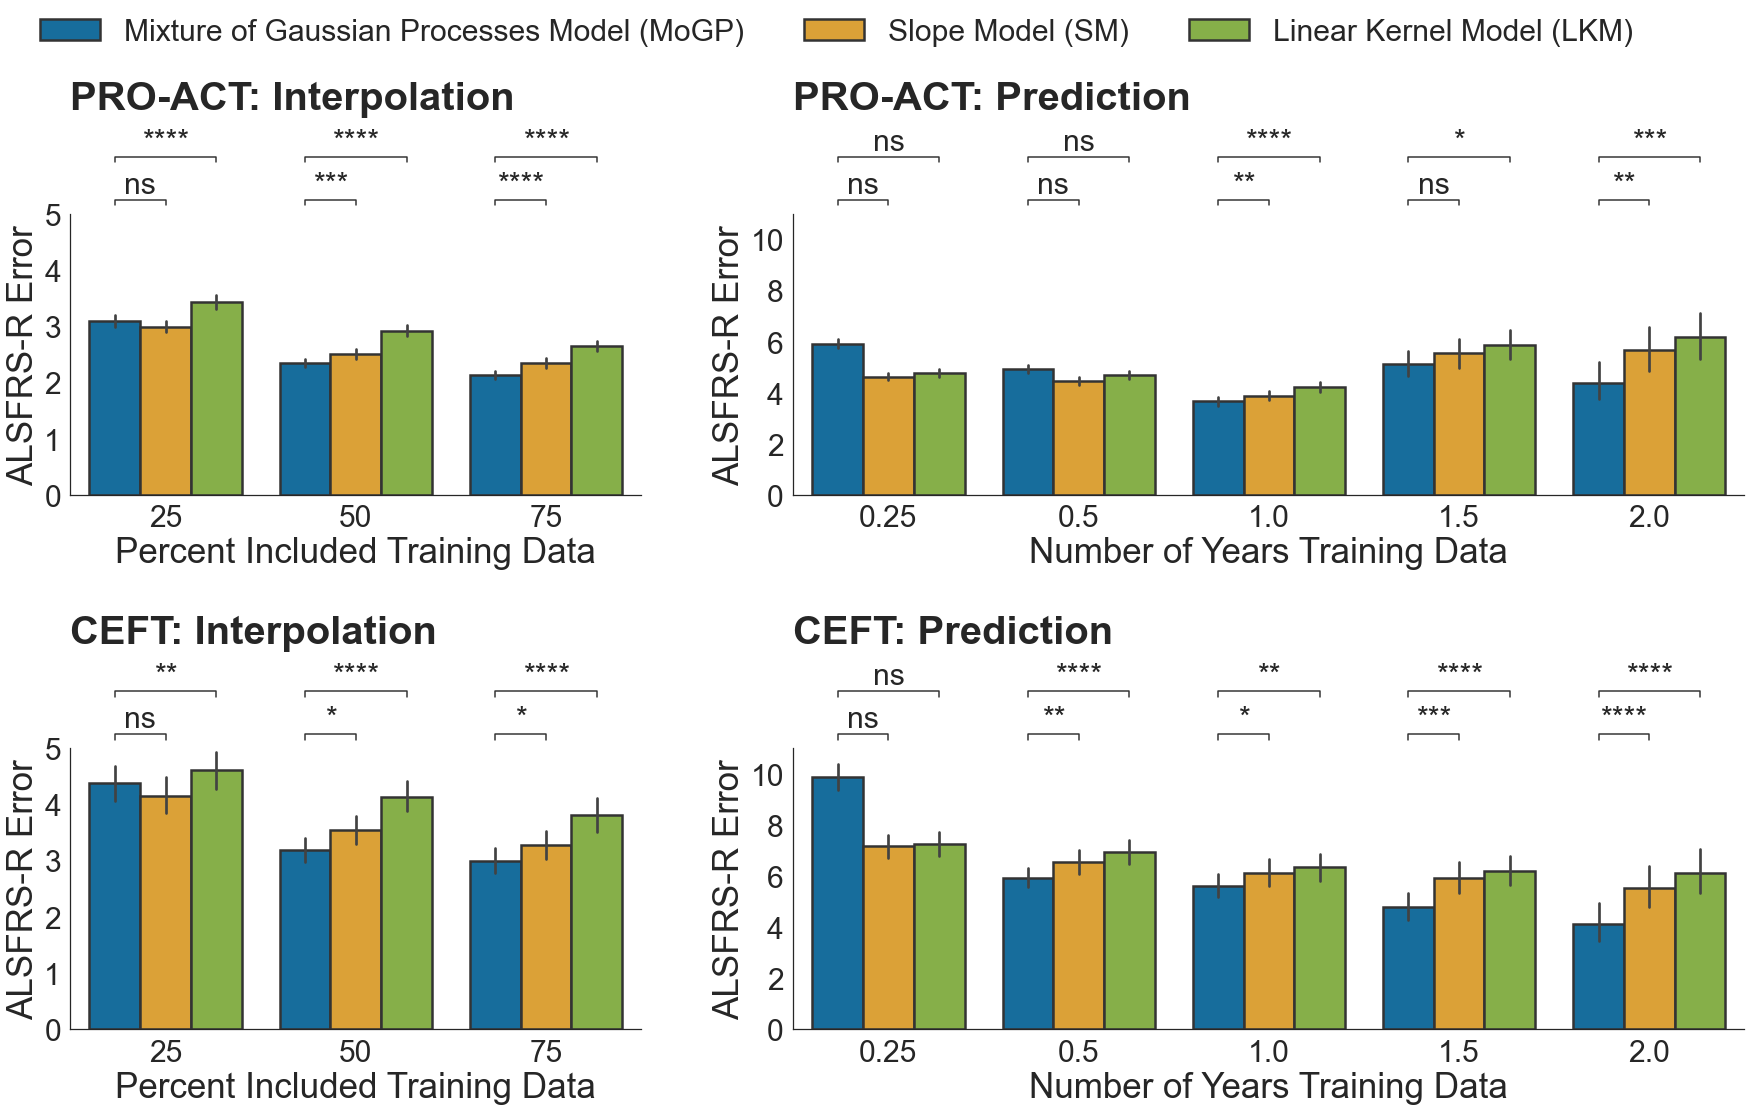

In [9]:
# Plot Figure
yticks_5 = [0, 1, 2, 3, 4, 5]
yticks_10 = [0, 2, 4, 6, 8, 10]

fig, axs = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 5/3], 'wspace':0.2, 'hspace':0.9}, figsize=(30, 15))
curax_1, handles, labels = plot_bars_task(axs.flat[0], proact_sparse_err_merge, 'err', 'Percent Included Training Data', axtitle='PRO-ACT: Interpolation', ylim=[0, 5], yticks=yticks_5, legend_labels=legend_labels, col_palette=col_palette)
_ = curax_1.legend(handles,  labels, frameon=False, loc='lower left', bbox_to_anchor=(-0.1, 1.5), ncol=3, fontsize=30) 
curax_2, handles, labels = plot_bars_task(axs.flat[1], proact_pred_err_merge, 'err', 'Number of Years Training Data', axtitle='PRO-ACT: Prediction', ylim=[0, 11], yticks=yticks_10, legend_labels=legend_labels, col_palette=col_palette)
_, _, _ = plot_bars_task(axs.flat[2], ceft_sparse_err_merge, 'err', 'Percent Included Training Data', axtitle='CEFT: Interpolation', ylim=[0, 5], yticks=yticks_5, legend_labels=legend_labels, col_palette=col_palette)
_, _, _ = plot_bars_task(axs.flat[3], ceft_pred_err_merge, 'err', 'Number of Years Training Data', axtitle='CEFT: Prediction', ylim=[0, 11], yticks=yticks_10, legend_labels=legend_labels, col_palette=col_palette)

# Save figure
fig.savefig('reports/fig_mogp_pred_sparse_barplots.pdf', bbox_inches='tight')

## Supplement Figure 2:  Number of clusters in MAP for prediction/interpolation models

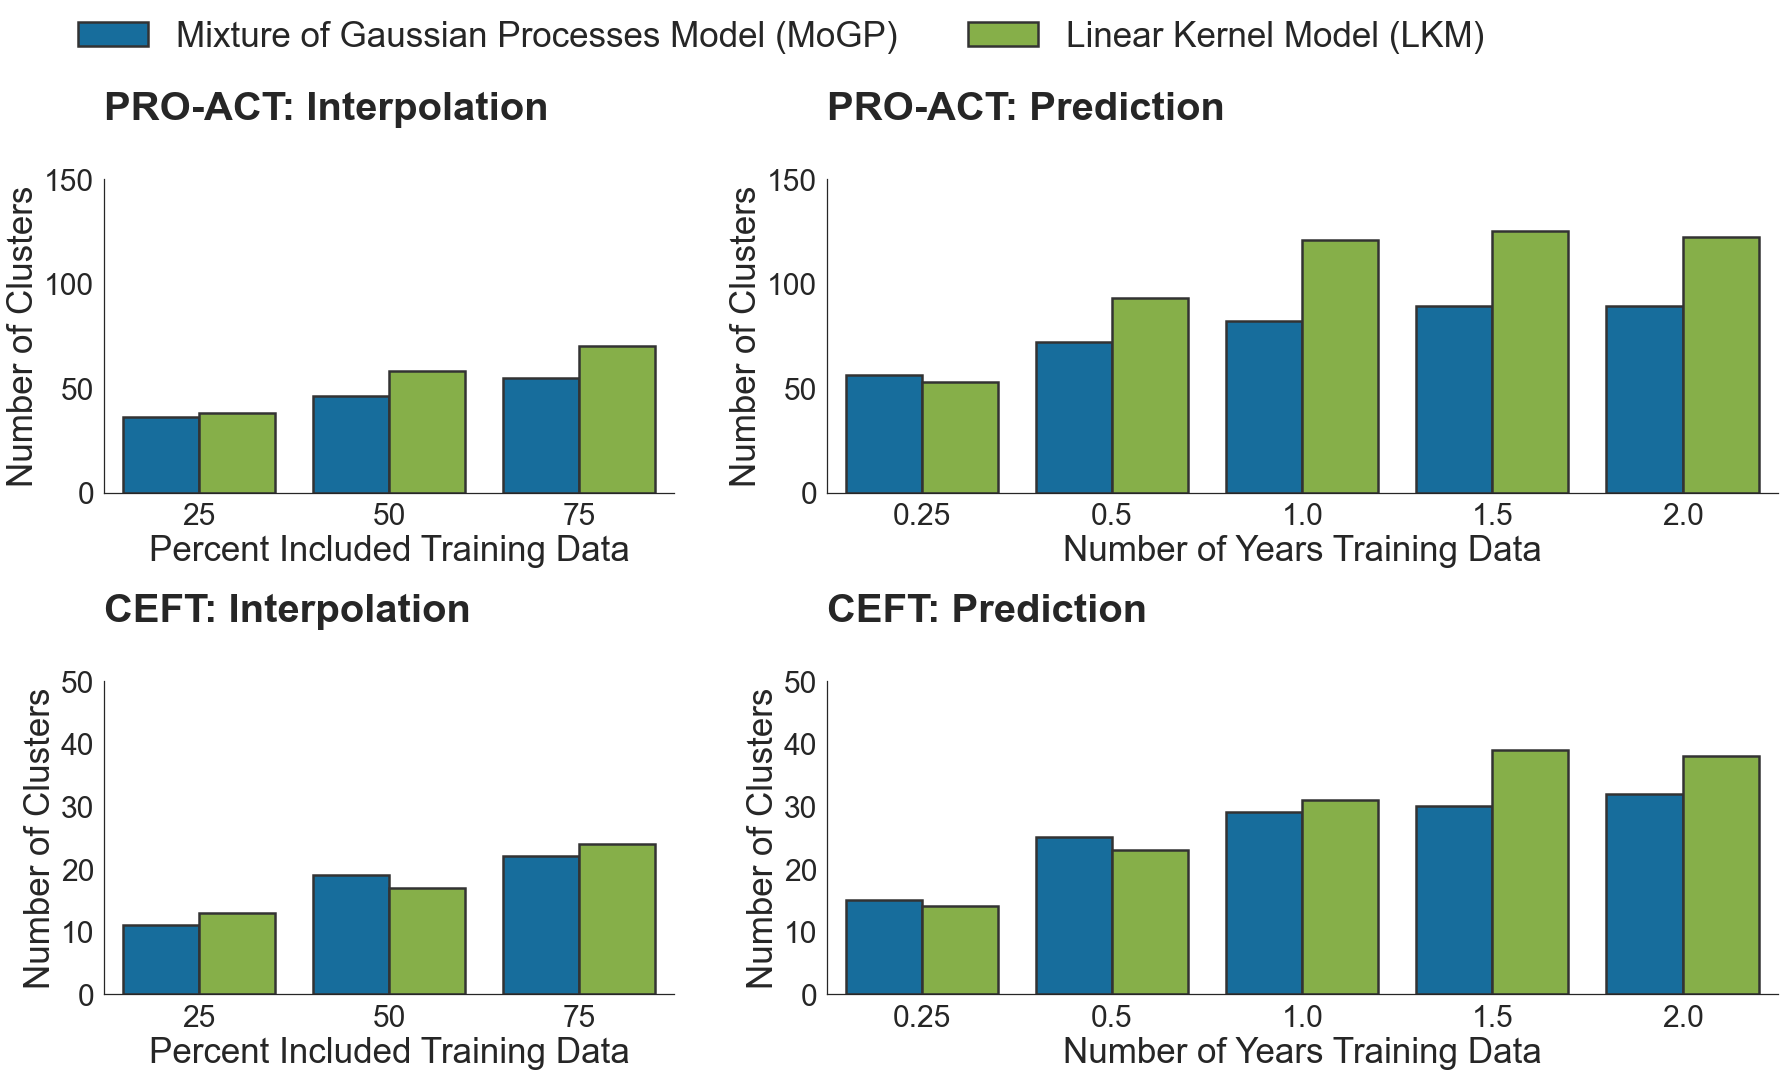

In [10]:
col_palette_cn = ['#176D9C', '#86AF49']  #Set colors to match prior figure

ylim_sparse_pro = [0,150]
ylim_pred_pro = [0,150]
ylim_sparse_cef = [0,50]
ylim_pred_cef = [0,50]

fig, axs = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 5/3], 'wspace': 0.2, 'hspace': 0.6}, figsize=(30, 15))
curax, handles, labels = plot_bars_cn(axs.flat[0], proact_sparse_cn_merge, 'num_clust', 'Percent Included Training Data', legend_labels=legend_labels_cn, axtitle='PRO-ACT: Interpolation', ylim=ylim_sparse_pro, col_palette=col_palette_cn)
_ = curax.legend(handles, labels, loc='lower left', bbox_to_anchor=(-0.1, 1.3), ncol=2)
curax, handles, labels = plot_bars_cn(axs.flat[1], proact_pred_cn_merge, 'num_clust', 'Number of Years Training Data', legend_labels=legend_labels_cn, axtitle='PRO-ACT: Prediction', ylim=ylim_pred_pro, col_palette=col_palette_cn)
_, _, _ = plot_bars_cn(axs.flat[2], ceft_sparse_cn_merge, 'num_clust', 'Percent Included Training Data', legend_labels=legend_labels_cn, axtitle='CEFT: Interpolation', ylim=ylim_sparse_cef, col_palette=col_palette_cn)
_, _, _ = plot_bars_cn(axs.flat[3], ceft_pred_cn_merge, 'num_clust', 'Number of Years Training Data', legend_labels=legend_labels_cn, axtitle='CEFT: Prediction', ylim=ylim_pred_cef, col_palette=col_palette_cn)

# Save figure
fig.savefig('reports/supp_fig_mogp_pred_sparse_clust_num.pdf', bbox_inches='tight')

## Dataframes for prediction/interpolation experiments

Note: Minor variances expected with subsequent runs in GPy predictions

In [11]:
print('proact-sparsity')
proact_sparse_err_merge.groupby(['type', 'task_num']).mean().round(2)
print('ceft-sparsity')
ceft_sparse_err_merge.groupby(['type', 'task_num']).mean().round(2)
print('difference-sparsity')
diff_calc = proact_sparse_err_merge.groupby(['type', 'task_num']).mean().loc['rbf']-proact_sparse_err_merge.groupby(['type', 'task_num']).mean().loc['slope']
diff_calc.round(2)

# Dataframes for sparsity experiments
print('proact-pred')
proact_pred_err_merge.groupby(['type', 'task_num']).mean().round(2)
print('ceft-pred')
ceft_pred_err_merge.groupby(['type', 'task_num']).mean().round(2)
print('difference-pred')
diff_calc = proact_pred_err_merge.groupby(['type', 'task_num']).mean().loc['rbf']-proact_pred_err_merge.groupby(['type', 'task_num']).mean().loc['slope']
diff_calc.round(2)

proact-sparsity


err  seed  best_ll
type   task_num                     
linear 25        3.43   4.0 -2562.46
       50        2.92   1.0 -3833.63
       75        2.64   2.0 -4081.39
rbf    25        3.09   0.0 -1902.03
       50        2.35   1.0 -1852.35
       75        2.13   1.0 -1228.56
slope  25        2.99   NaN      NaN
       50        2.51   NaN      NaN
       75        2.35   NaN      NaN

ceft-sparsity


err  seed  best_ll
type   task_num                     
linear 25        4.61   2.0  -524.63
       50        4.13   0.0  -905.05
       75        3.82   4.0 -1131.05
rbf    25        4.37   2.0  -382.49
       50        3.19   1.0  -504.39
       75        2.99   4.0  -543.20
slope  25        4.15   NaN      NaN
       50        3.54   NaN      NaN
       75        3.27   NaN      NaN

difference-sparsity


,err,seed,best_ll
task_num,,,
25,0.10,NaN,NaN
50,-0.17,NaN,NaN
75,-0.22,NaN,NaN


proact-pred


err  seed   best_ll
type   task_num                      
linear 0.25      4.77   1.0  -4862.94
       0.5       4.71   3.0  -7217.85
       1.0       4.21   2.0  -9701.65
       1.5       5.86   3.0 -10461.08
       2.0       6.18   4.0 -10359.72
rbf    0.25      5.92   2.0  -4176.12
       0.5       4.91   4.0  -5132.45
       1.0       3.67   3.0  -4745.68
       1.5       5.14   2.0  -4112.83
       2.0       4.40   2.0  -4008.08
slope  0.25      4.62   NaN       NaN
       0.5       4.46   NaN       NaN
       1.0       3.89   NaN       NaN
       1.5       5.54   NaN       NaN
       2.0       5.68   NaN       NaN

ceft-pred


err  seed  best_ll
type   task_num                     
linear 0.25      7.26   0.0  -760.82
       0.5       6.94   2.0 -1196.43
       1.0       6.34   0.0 -1642.83
       1.5       6.21   4.0 -1908.82
       2.0       6.12   3.0 -2106.49
rbf    0.25      9.88   0.0  -671.97
       0.5       5.93   2.0 -1104.75
       1.0       5.62   2.0 -1110.93
       1.5       4.80   4.0 -1175.01
       2.0       4.13   4.0 -1133.40
slope  0.25      7.17   NaN      NaN
       0.5       6.53   NaN      NaN
       1.0       6.12   NaN      NaN
       1.5       5.91   NaN      NaN
       2.0       5.52   NaN      NaN

difference-pred


,err,seed,best_ll
task_num,,,
0.25,1.30,NaN,NaN
0.5,0.46,NaN,NaN
1.0,-0.22,NaN,NaN
1.5,-0.41,NaN,NaN
2.0,-1.28,NaN,NaN
